# Imports

In [1]:
import numpy as np
import numpy.typing as npt
import seaborn as sns
import tifffile as tiff
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import cv2
from scipy.stats import skew
import sys
import numpy.typing as npt


import hdbscan
import umap
import umap.plot


import torch
import torchvision
import gc
import glob


In [2]:
%load_ext autoreload
%autoreload 2


import importlib  
au = importlib.import_module("cell-AAP.cell_AAP.annotation.annotation_utils")
sys.path.append('/home/anishjv/cell_seg_classify/notebooks/cell-AAP/cell_AAP/annotation/')
sys.path.append('/home/anishjv/cell_seg_classify/notebooks/cell-AAP/')
ann = importlib.import_module("cell-AAP.cell_AAP.annotation.annotator")
dw = importlib.import_module("cell-AAP.cell_AAP.annotation.dataset_write")
cfg = importlib.import_module("cell-AAP.cell_AAP.configs")

# Model Info
Here is where you define the SAM model to be used

In [3]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.modeling import Sam

#Code below should be run if file is not already saved in path 
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam_checkpoint = "vit_l.pt"
model_type = "vit_l"
device = 'cuda'
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device = device)
predictor = SamPredictor(sam)

In [4]:
paths = [
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250429-cellapp-data/20250428-cellapp-hela-t0-f0/HeLa-Rpe1-cellapp-data/2025-04-29/20411',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250429-cellapp-data/20250428-cellapp-hela-t0-f1/HeLa-Rpe1-cellapp-data/2025-04-29/20413',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250429-cellapp-data/20250428-cellapp-hela-t0-f2/HeLa-Rpe1-cellapp-data/2025-04-29/20414',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250429-cellapp-data/20250428-cellapp-hela1-t1-f0/HeLa-Rpe1-cellapp-data/2025-04-29/20421',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250429-cellapp-data/20250428-cellapp-hela1-t1-f1/HeLa-Rpe1-cellapp-data/2025-04-29/20422',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250429-cellapp-data/20250428-cellapp-hela1-t1-f2/HeLa-Rpe1-cellapp-data/2025-04-29/20423',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250429-cellapp-data/20250428-cellapp-hela1-t2-f0/HeLa-Rpe1-cellapp-data/2025-04-29/20424',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250429-cellapp-data/20250428-cellapp-hela1-t2-f1/HeLa-Rpe1-cellapp-data/2025-04-29/20425',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250429-cellapp-data/20250428-cellapp-hela1-t2-f2/HeLa-Rpe1-cellapp-data/2025-04-29/20426',    
]

fluoro_files = []
phs_files = []
for path in paths:
    fluoro_files += glob.glob(path+'/*Texas Red.tif')
    phs_files += glob.glob(path+'/*phs.tif')
    
    
train_phs_files = sorted([file for file in phs_files if 'A01' not in file])
test_phs_files = sorted([file for file in phs_files if 'A01' in file])

train_fluoro_files = sorted([file for file in fluoro_files if 'A01' not in file])
test_fluoro_files = sorted([file for file in fluoro_files if 'A01' in file])

fluoro_files = train_fluoro_files + test_fluoro_files
phs_files = train_phs_files + test_phs_files

# Object Oriented Dataset Creation 

In this notebook we will demonstrate usage of the **Annotator** class to automate dataset generation. Here dataset creation requires two steps.

1. Instantiate an instance of the **Cfg** class and call the class method **get_config** which defaults to the configurations for HeLA cells. 

2. Instantiate an instance of the **Annotator** class and call the class method **get**. The method takes 3 arguments 

    - 'configs', an instance of the Cfg class.
    - 'dna_image_list', list of dna stain microscopy tiff images 
    - 'phase_image_list', list of phase microscopy tiff images
         #
2. Call the methods **crop** and **gen_df** on the instance you instantiated in the last step

We can then use UMAP and HDBSCAN to find meaningful groupings within our dataset

In [5]:
%%time
configs = cfg.Cfg.get_config()
configs.frame_step = 1
configs.iou_thresh = 0.95

def sd_intensity(regionmask, intensity_image):
        return np.std(intensity_image[regionmask])

instance_whole = ann.Annotator.get(configs,fluoro_files,phs_files)

df_whole = instance_whole.crop(predictor = predictor).gen_df(extra_props = (sd_intensity,))

The bounding box side length was 78.69676014001004 pixels
input list: 41
input list: 39
poped indices:2
The bounding box side length was 86.96697006487248 pixels
input list: 55
input list: 55
poped indices:0
The bounding box side length was 75.5657074608711 pixels
input list: 97
input list: 96
poped indices:1
The bounding box side length was 76.95138962516555 pixels
input list: 144
input list: 142
poped indices:2
The bounding box side length was 82.53462755423988 pixels
input list: 58
input list: 58
poped indices:0
The bounding box side length was 77.90518768275507 pixels
input list: 83
input list: 83
poped indices:0
The bounding box side length was 76.86536270933169 pixels
input list: 174
input list: 174
poped indices:0
The bounding box side length was 80.25530152000526 pixels
input list: 51
input list: 51
poped indices:0
The bounding box side length was 76.63895416473613 pixels
input list: 87
input list: 87
poped indices:0
The bounding box side length was 77.25422513059556 pixels
inp

In [17]:
df_whole = instance_whole.gen_df(extra_props = (sd_intensity, ))

In [69]:
df_whole_nolabels = df_whole[:, 0:16]

In [ ]:
np.save('embeddings/hela.npy', df_whole)
np.save('embeddings/hela_crops.npy', instance_whole.roi)

In [70]:
df_mapper = umap.UMAP(n_neighbors=25,
                   min_dist=0,
                   n_components=2,
                   random_state=42,).fit(df_whole_nolabels)

df_embedding = umap.UMAP(n_neighbors=25,
                                  min_dist=0,
                                  n_components=2,
                                  random_state=42,
                                 ).fit_transform(df_whole_nolabels)

/home/anishjv/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/anishjv/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [86]:
labels_whole_embedding = hdbscan.HDBSCAN(min_samples=50,
                                        min_cluster_size = 4000,
                                        ).fit_predict(df_embedding)

df_whole_labeled = au.add_labels(df_whole, labels_whole_embedding)

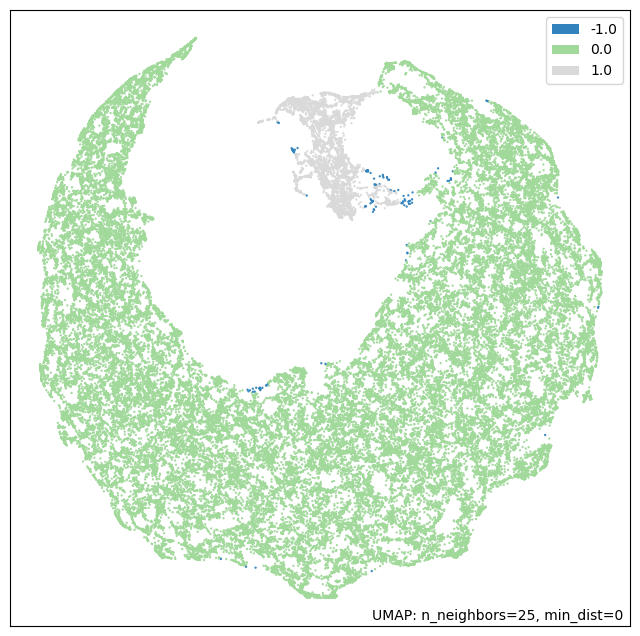

In [87]:
fig = umap.plot.points(df_mapper, labels = df_whole_labeled[:, -1], theme = "green").get_figure()



In [17]:
fig.savefig('/home/anishjv/cell_seg_classify/post-review-cellapp-paper/figures/umap.svg', dpi = 100)

In [96]:
clusters = au.write_clusters(df_whole_labeled, -1)
for cluster in clusters.values():
    print(cluster.shape)

(58337, 2)
(4355, 2)
(125, 2)


# Classification 

Below we display the results of cell classification by UMAP and HDBSCAN. Each code cell plots a sample of ROI's from one cluster. Each cluster has been created by UMAP and HDBSCAN in a way such that ROI's within the same cluster share similar properties. 

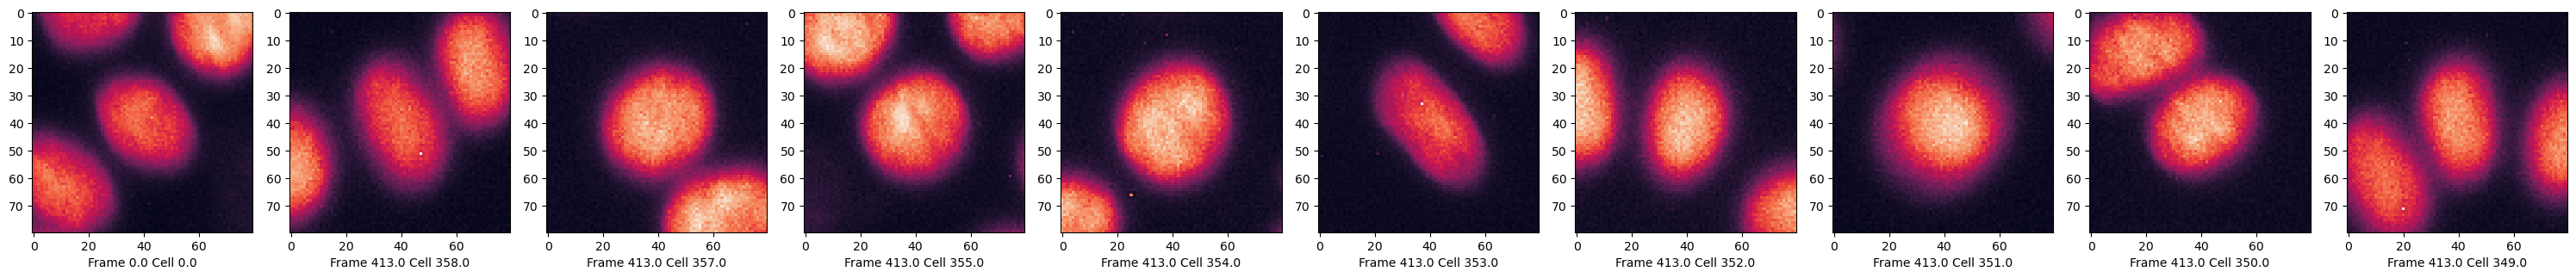

In [97]:
fig, ax = plt.subplots(ncols = 10, figsize = (30,20))

clus_num = 0
for i in range(10):
    ax[i].imshow(instance_whole.roi[int(clusters[clus_num][-i-10, 0])][int(clusters[clus_num][-i-10, 1])], cmap = 'rocket')
    ax[i].set_xlabel(f'Frame {clusters[clus_num][-i, 0]} Cell {clusters[clus_num][-i, 1]}')

plt.tight_layout()
plt.show()

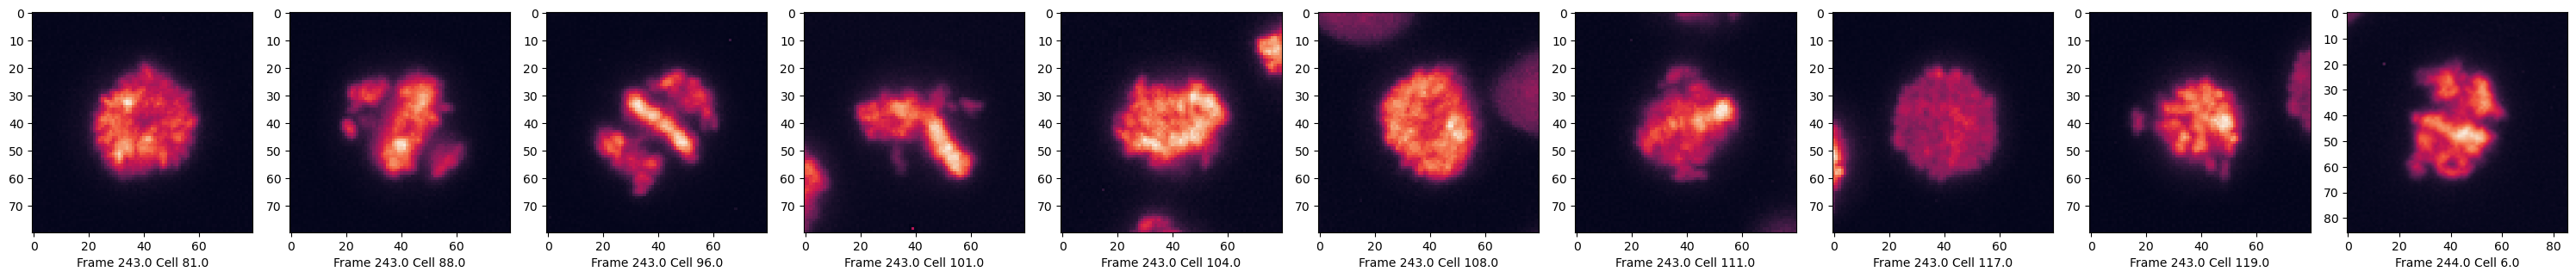

In [98]:
fig, ax = plt.subplots(ncols = 10, figsize = (30,20))

clus_num = 1
for i in range(10):
    j = i+2500
    ax[i].imshow(instance_whole.roi[int(clusters[clus_num][j, 0])][int(clusters[clus_num][j, 1])], cmap = 'rocket')
    ax[i].set_xlabel(f'Frame {clusters[clus_num][j, 0]} Cell {clusters[clus_num][j, 1]}')

plt.tight_layout()
plt.show()

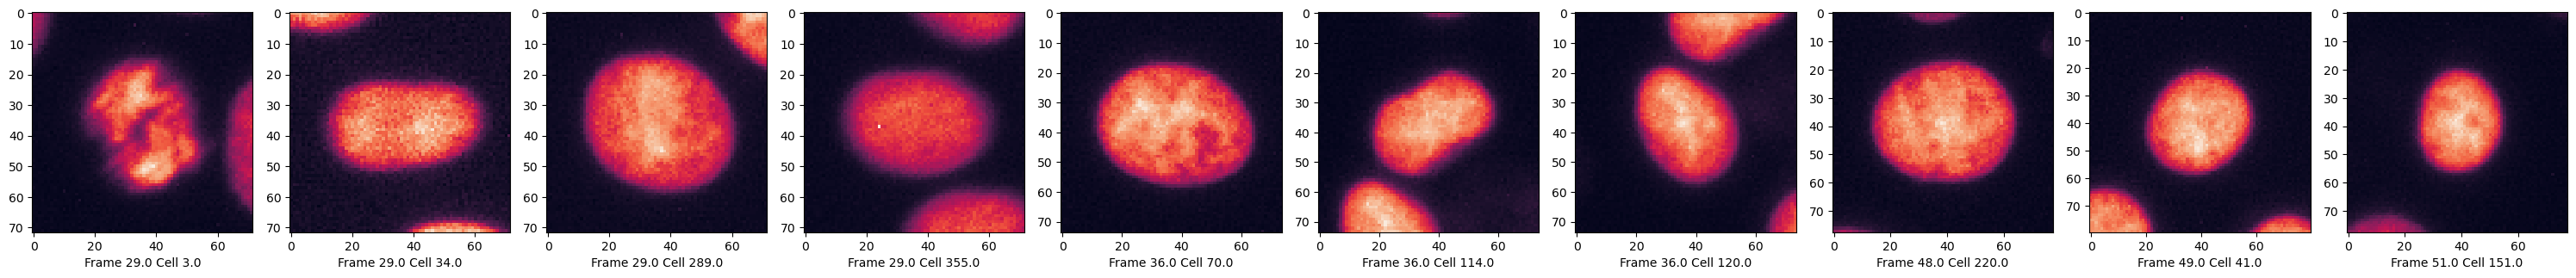

In [99]:
fig, ax = plt.subplots(ncols = 10, figsize = (30,20))

clus_num = 'noise'
for i in range(10):
    ax[i].imshow(instance_whole.roi[int(clusters[clus_num][i+10, 0])][int(clusters[clus_num][i+10, 1])], cmap = 'rocket')
    ax[i].set_xlabel(f'Frame {clusters[clus_num][i+10, 0]} Cell {clusters[clus_num][i+10, 1]}')

plt.tight_layout()
plt.show()

# SAM (Segment Anything Model)

We will now display the automatically generated cell segmentations produced by SAM, these segmentations can be used to train a specialized network algorithm. 

In [72]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=1))

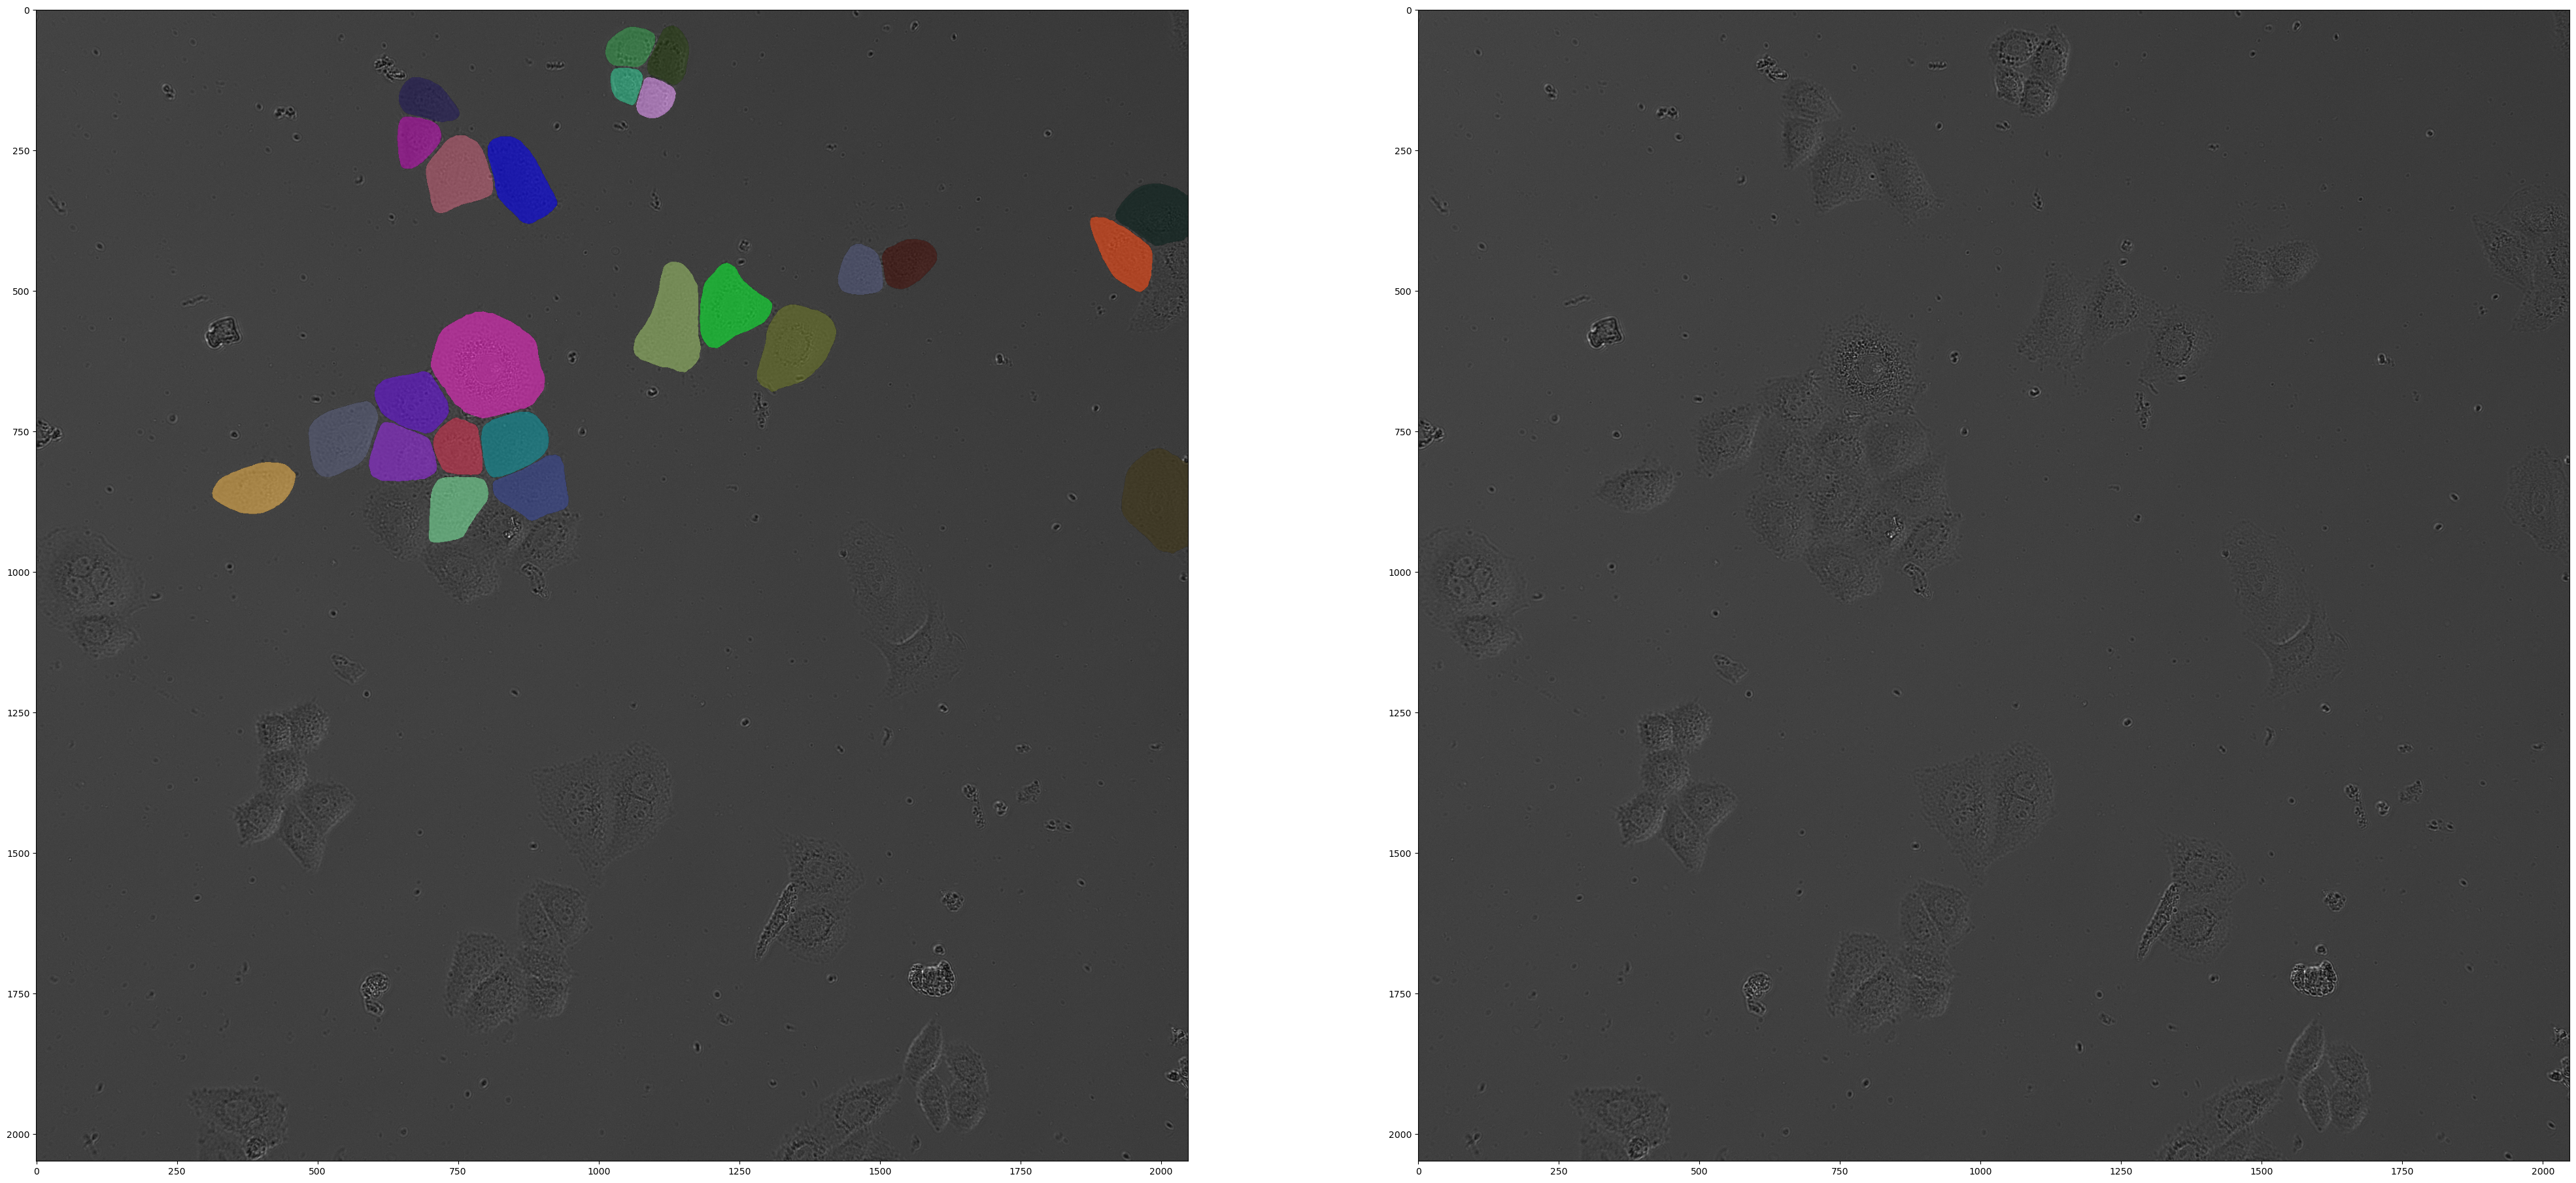

In [73]:
fig, ax = plt.subplots(ncols = 2, figsize = (50,50))

ax[0].imshow(au.bw_to_rgb(instance_whole.phase_image_stack[1]))
ax[1].imshow(au.bw_to_rgb(instance_whole.phase_image_stack[1]))
for i in range(25):
    mask = np.unpackbits(instance_whole.segmentations[1][i], axis = 0, count = 2048)
    mask = np.array([mask]).astype('uint8')
    show_mask(mask, ax[0], random_color = True)

plt.show()

# M-phase

As an exercise we will re-cluster the mitotic group to search for cells in the different stages of M phase.

In [105]:
df_mitotic = df_whole_labeled[df_whole_labeled[:, -1] == 1]
df_mitotic_nolabels = df_mitotic[:, 0:-1]

In [109]:
recluster_mapper = umap.UMAP(n_neighbors=8,
                   min_dist=0,
                   n_components=2,
                   random_state=42,).fit(df_mitotic_nolabels)

recluster_embedding = umap.UMAP(n_neighbors=8,
                                  min_dist=0,
                                  n_components=2,
                                  random_state=42,
                                 ).fit_transform(df_mitotic_nolabels)

/home/anishjv/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/anishjv/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [134]:
labeled_recluster_embedding = hdbscan.HDBSCAN(min_samples=10,
                                        min_cluster_size = 100
                                        ).fit_predict(recluster_embedding)

df_mitotic_labeled = au.add_labels(df_mitotic_nolabels, labeled_recluster_embedding)

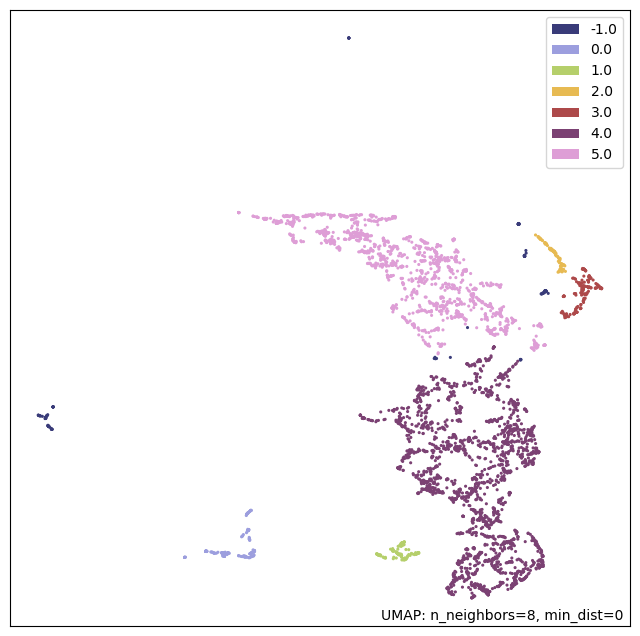

In [135]:
fig = umap.plot.points(recluster_mapper, labels = df_mitotic_labeled[:, -1], theme = "red").get_figure()


#fig.savefig('/home/anishjv/cell_seg_classify/post-review-cellapp-paper/figures/anph_clus_umap.png', dpi=500)

In [136]:
mphase_clusters = au.write_clusters(df_mitotic_labeled, -1)
for cluster in mphase_clusters.values():
    print(cluster.shape)

(176, 2)
(132, 2)
(106, 2)
(190, 2)
(2173, 2)
(1445, 2)
(133, 2)


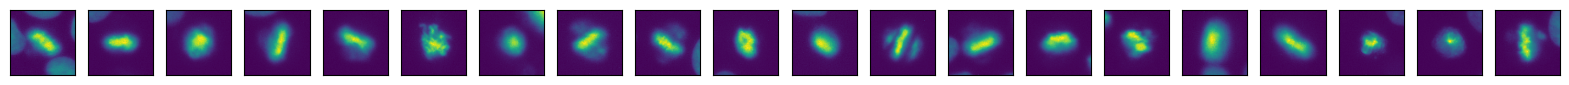

In [146]:
fig, ax = plt.subplots(ncols = 20, figsize = (20, 20))

clus_num = 5
for i in range(20):
    ax[i].imshow(instance_whole.roi[int(mphase_clusters[clus_num][i+5, 0])][int(mphase_clusters[clus_num][i+5, 1])])
    #ax[i].set_xlabel(f'Frame_{mphase_clusters[clus_num][i, 0]}_cell_{mphase_clusters[clus_num][i, 1]}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    

#fig.savefig('/home/anishjv/cell_seg_classify/post-review-cellapp-paper/figures/anph_clus_3.png', dpi=500)

# Writing the dataset

In [26]:
for i in range(df_whole_labeled.shape[0]):
    if df_whole_labeled[i, -1] in [0]:
        df_whole_labeled[i, -1] = 1 #mitotic
    else:
        df_whole_labeled[i, -1] = 0 #non-mitotic

In [9]:
splits = [
    (0, 269),
    (270, 413)
] #Breaks the dataset into testing and validation subsets by index of the phase_image_stack. In other words,
  # we split the dataset into subsets by image. You can have as many subsets as you desire. 

dw.write_dataset_ranges(
    '/home/anishjv/cell_seg_classify/datasets',
    phase_image_stack,
    segmentations,
    df_whole_labeled,
    splits,
    'HeLa_0.1',
    {0: 'nonmitotic', 1: 'mitotic'} #Dictionary mapping label in the dataset to category name
)